Try to generate room imprints with pre-defined templates and seeds

In [194]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as img

import random
from grid import *
import cv2 as cv
import os

In [195]:
print(os.getcwd())

c:\Users\mehds\Documents\EPFL\MA4\Procedural_Building_Generation\ProceduralBuildingGeneration


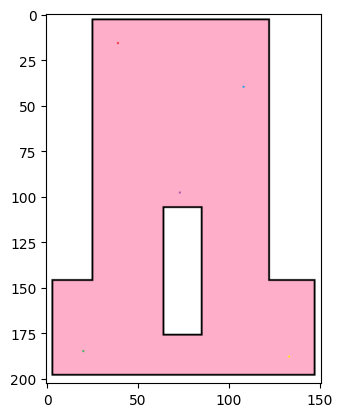

In [196]:
floorplans = []
data_dir = "data/pre_defined/"
for filename in os.listdir(data_dir):
    if filename.lower().endswith(('.png', 'jpeg')):
        filepath = os.path.join(data_dir, filename)
        floorplan = cv.imread(filepath)
        floorplan = cv.cvtColor(floorplan, cv.COLOR_BGR2RGB)
        plt.imshow(floorplan)
        floorplans.append(floorplan)

(684, 760, 3)


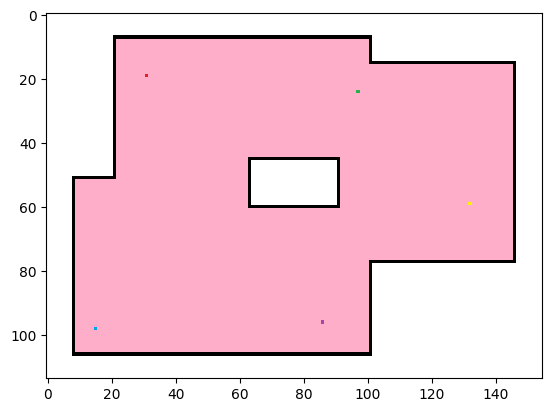

In [197]:
plt.imshow(floorplans[1])
print(floorplans[0].shape)

In [198]:
def image_to_int(floorplan):
    """
    Processes a floorplan image and converts it into a NumPy array with specific values.
    Also extracts the coordinates of seed pixels.
    Args:
        floorplan: Floorplan to be processed

    Returns:
        np.array: Processed NumPy array.
        list: List of seed coordinates in the format [(x1, y1, value1), (x2, y2, value2), ...].
    """
    color_to_value = {
        (0, 0, 0): 1,          # Walls (black)
        (255, 255, 255): 0,    # Outside (white)
        (255, 174, 201): 255,  # Inside (pink)
        (237, 28, 36): 128,      # Seed 1 (red)
        (0, 162, 232): 129,      # Seed 2 (blue)
        (34, 177, 76): 130,      # Seed 3 (green)
        (163, 73, 164): 132,    # Seed 4 (purple)
        (255, 127, 39): 136,    # Seed 5 (orange)
        (255, 242, 0): 144     # Seed 6 (yellow)
    }
    y_max, x_max, _ = floorplan.shape
    floorplan_int = np.zeros((y_max, x_max), dtype=np.uint8)
    seeds = []

    for y in range(y_max):
        for x in range(x_max):
            pixel = tuple(floorplan[y, x])
            if pixel in color_to_value:
                floorplan_int[y, x] = color_to_value[pixel]
                if floorplan_int[y, x] in [128, 129, 130, 132, 136, 144]:
                    seeds.append((x, y, floorplan_int[y, x]))
            else:
                raise ValueError(f"Unexpected color {pixel} at position ({x}, {y})")

    return floorplan_int, seeds

In [199]:
def plot_floorplan(output_array, seed_coordinates, save=False):
    """
    Plots the processed floorplan and highlights seed coordinates.

    Args:
        output_array (np.array): Processed floorplan array.
        seed_coordinates (list): List of seed coordinates in the format [(x1, y1, value1), ...].
    """
    plt.figure(figsize=(10, 10))
    plt.imshow(output_array, cmap="viridis", vmin=0, vmax=255)
    plt.colorbar(label="Pixel Value")
    plt.title("Processed Floorplan")
    for seed in seed_coordinates:
        print(seed)
        x, y, value = seed
        plt.scatter(x, y, color="red", s=50, edgecolors="white", label=f"Seed {value}")
        plt.text(x, y, f"{value}", color="white", fontsize=12, ha="center", va="center")

    handles, labels = plt.gca().get_legend_handles_labels()
    by_label = dict(zip(labels, handles))
    if (save):
        filename = f"Floor_{seed_coordinates[0][0]}.png"  # Use the first seed's x-coordinate in the filename
        plt.savefig(filename, dpi=300, bbox_inches="tight")  # Save with high resolution and tight bounding box
    plt.show()
    plt.close()  # Close the figure to free up memory



In [200]:
floorplans_int, seeds = [], []
for floorplan in floorplans[1:]:
    floorplan_int, seed = image_to_int(floorplan)
    #plot_floorplan(floorplan_int, seed)
    floorplans_int.append(floorplan_int)
    seeds.extend([seed])

In [201]:
print(seeds[0][0])

(31, 19, 128)


(21, 16, 130)
(107, 16, 129)
(55, 44, 144)
(116, 57, 132)
(20, 86, 128)


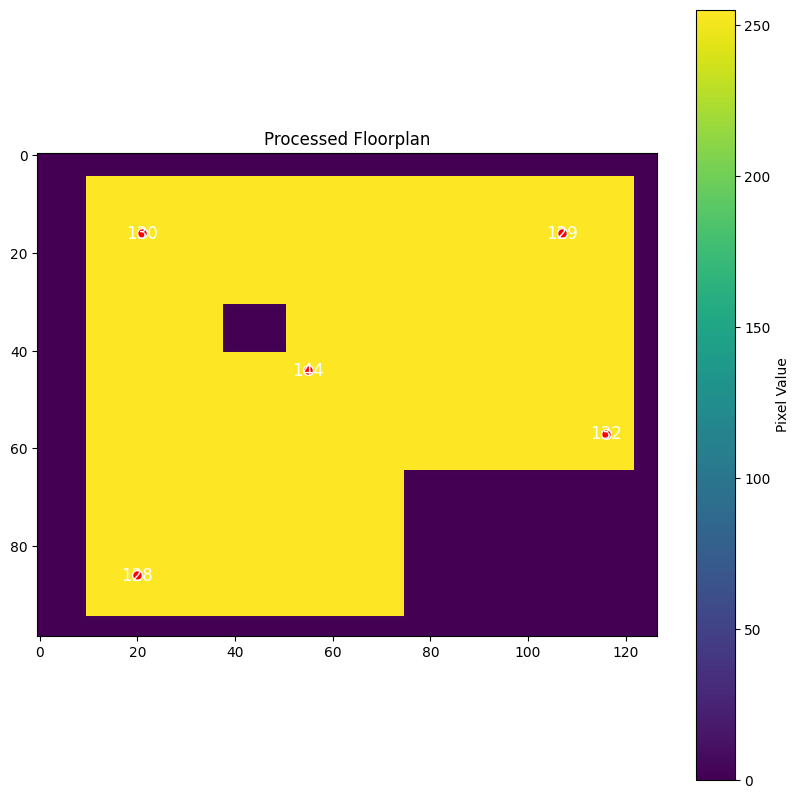

(99, 127)


In [202]:
plot_floorplan(floorplans_int[1], seeds[1])
print(floorplans_int[1].shape)

In [217]:
import numpy as np
from collections import deque

def region_growing_simultaneous(grid, seeds, connectivity=4):
    """
    Grows seeds simultaneously by 1 pixel per round.
    Args:
        grid (np.array): Input floorplan grid.
        seeds (list): List of seed coordinates [(x1, y1, value1), ...].
        connectivity (int): 4 or 8 for 4-connected or 8-connected growth.
    Returns:
        np.array: Grid with grown regions.
    """
    # Create a copy of the grid to store the result
    result = grid.copy()
    # Define directions based on connectivity
    if connectivity == 4:
        directions = [(-1, 0), (1, 0), (0, -1), (0, 1)]  # 4-connected
    elif connectivity == 8:
        directions = [(-1, -1), (-1, 0), (-1, 1),
                      (0, -1),          (0, 1),
                      (1, -1),  (1, 0), (1, 1)]  # 8-connected
    else:
        raise ValueError("Connectivity must be 4 or 8.")

    # Initialize a queue with all seeds
    queue = deque()
    for x, y, value in seeds:
        queue.append((y, x, value))  # Store (x, y, value) for each seed
        result[y, x] = value  # Mark the seed position in the result grid

    # Perform simultaneous region growing
    while queue:
        round_size = len(queue)# Process all pixels in the current round
        for _ in range(round_size):
            x, y, value = queue.popleft()
            for dx, dy in directions:
                nx, ny = x + dx, y + dy
                # Check if the neighbor is inside (255) and not already assigned
                if 0 <= nx < grid.shape[0] and 0 <= ny < grid.shape[1] and result[nx, ny] == 255:
                    # Check if the neighbor has any adjacent pixels from other regions
                    has_adjacent_region = False
                    for ddy, ddx in directions:
                        nny, nnx = ny + ddy, nx + ddx
                        if 0 <= nnx < grid.shape[0] and 0 <= nny < grid.shape[1]:
                            if result[nnx, nny] != 255 and (result[nnx, nny] != 1 and result[nnx, nny] != value):
                                has_adjacent_region = True
                                break
                    # If no adjacent regions, assign the value
                    if not has_adjacent_region:
                        result[nx, ny] = value  # Assign the seed's value
                        queue.append((nx, ny, value))  # Add to the queue for the next round
    #return result
        # Create a reverse mapping from seed values to RGB colors
    reverse_mapping = {
        128: (237, 28, 36),      # Seed 1 (red)
        129: (0, 162, 232),      # Seed 2 (blue)
        130: (34, 177, 76),      # Seed 3 (green)
        132: (163, 73, 164),     # Seed 4 (purple)
        136: (255, 127, 39),     # Seed 5 (orange)
        144: (255, 242, 0)      # Seed 6 (yellow)
    }

    # Create a color-coded grid
    color_coded_grid = np.zeros((result.shape[0], result.shape[1], 3), dtype=np.uint8)
    for y in range(result.shape[0]):
        for x in range(result.shape[1]):
            value = result[y, x]
            if value in reverse_mapping:
                color_coded_grid[y, x] = reverse_mapping[value]
            elif value == 1:  # Walls
                color_coded_grid[y, x] = (0, 0, 0)  # Black
            elif value == 0:  # Outside
                color_coded_grid[y, x] = (255, 255, 255)  # White
            elif value == 255:  # Inside (unassigned)
                color_coded_grid[y, x] = (255, 192, 203)  # Pink

    return color_coded_grid

4-Connected Result:
(21, 16, 130)
(107, 16, 129)
(55, 44, 144)
(116, 57, 132)
(20, 86, 128)


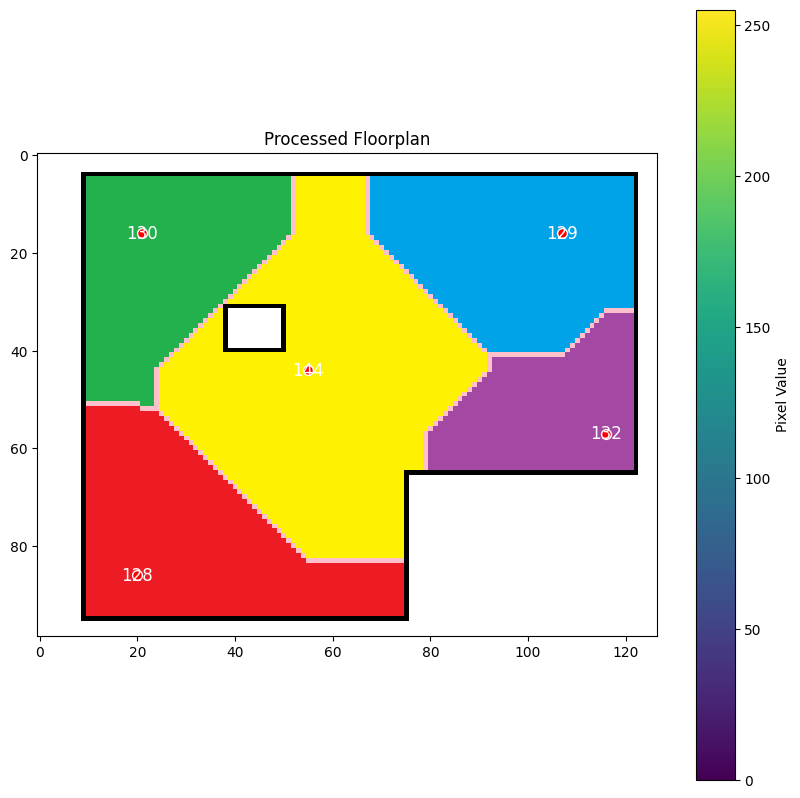

4-Connected Result:
(131, 17, 128)
(35, 23, 144)
(45, 72, 130)
(90, 78, 132)
(124, 112, 129)


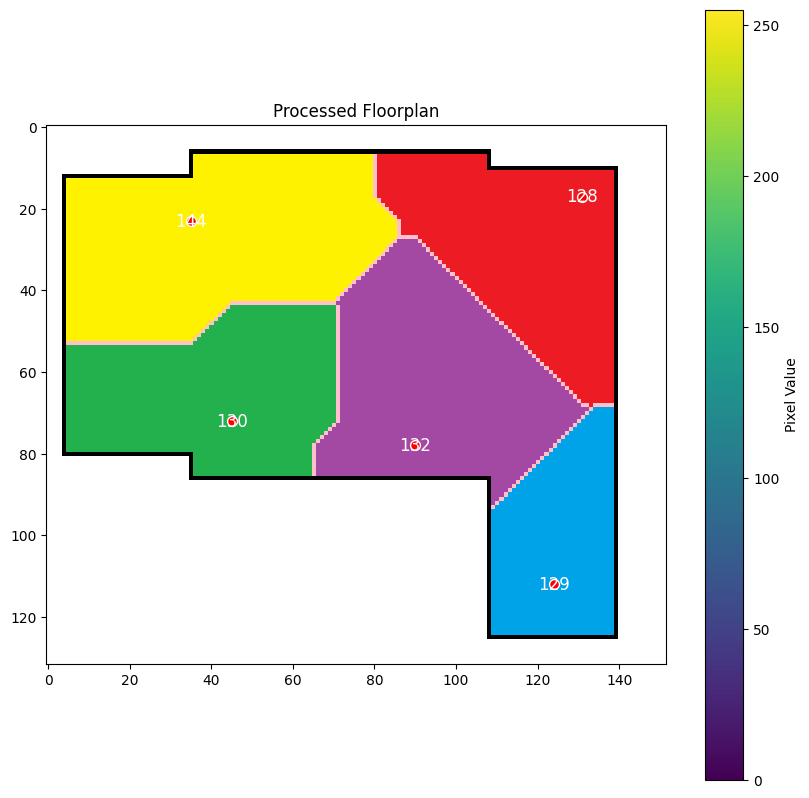

4-Connected Result:
(96, 9, 136)
(20, 14, 144)
(176, 14, 129)
(98, 54, 130)
(16, 122, 128)
(183, 128, 132)


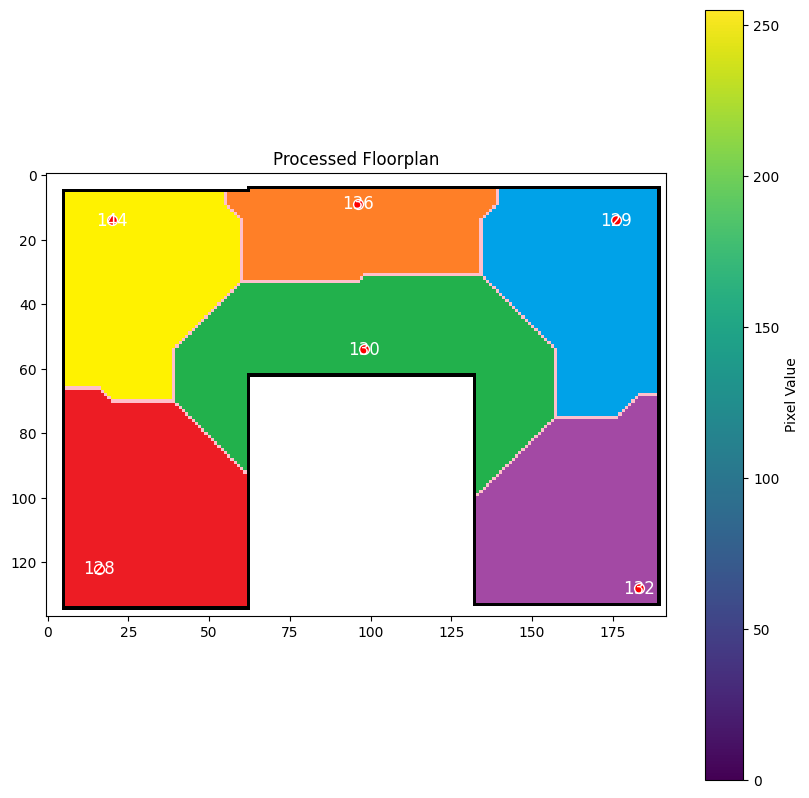

4-Connected Result:
(106, 11, 130)
(16, 12, 128)
(55, 60, 132)
(18, 101, 144)
(103, 104, 129)


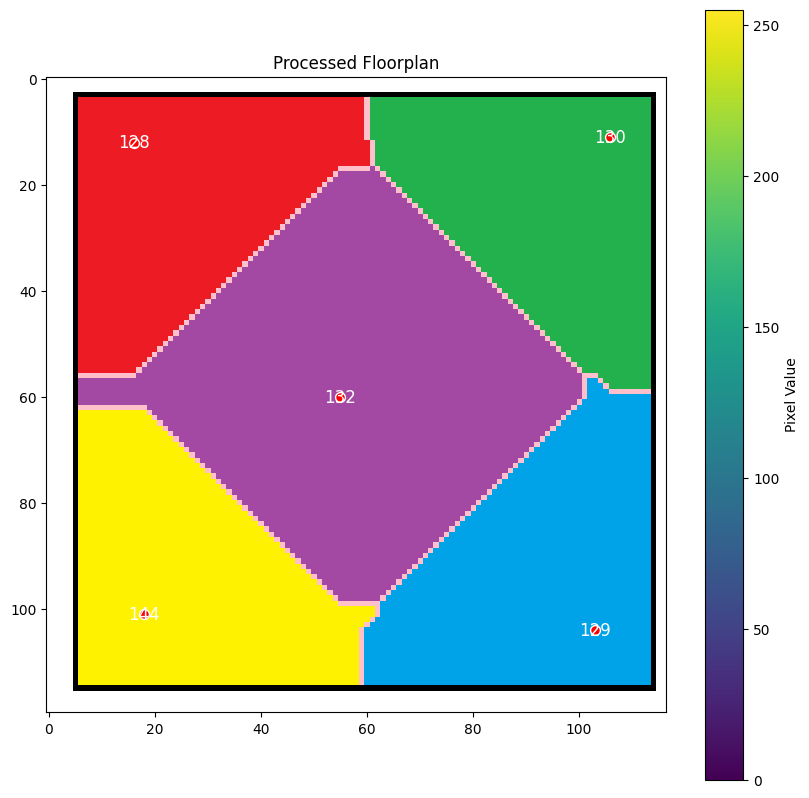

4-Connected Result:
(116, 9, 132)
(12, 16, 130)
(197, 69, 129)
(70, 92, 144)
(18, 150, 128)
(137, 164, 136)


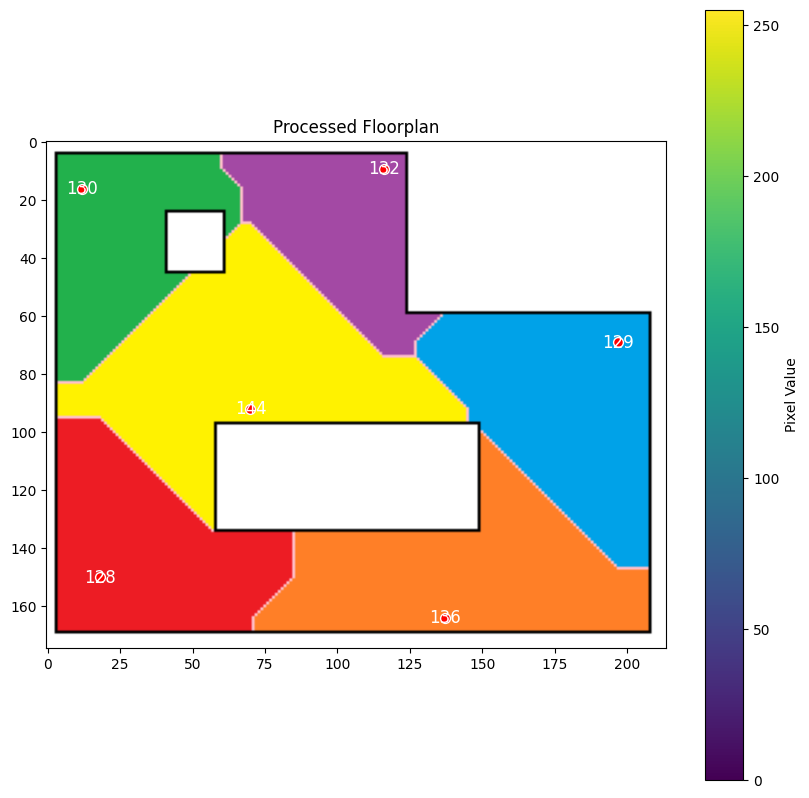

4-Connected Result:
(167, 9, 130)
(65, 16, 132)
(14, 34, 128)
(112, 49, 144)
(218, 59, 129)


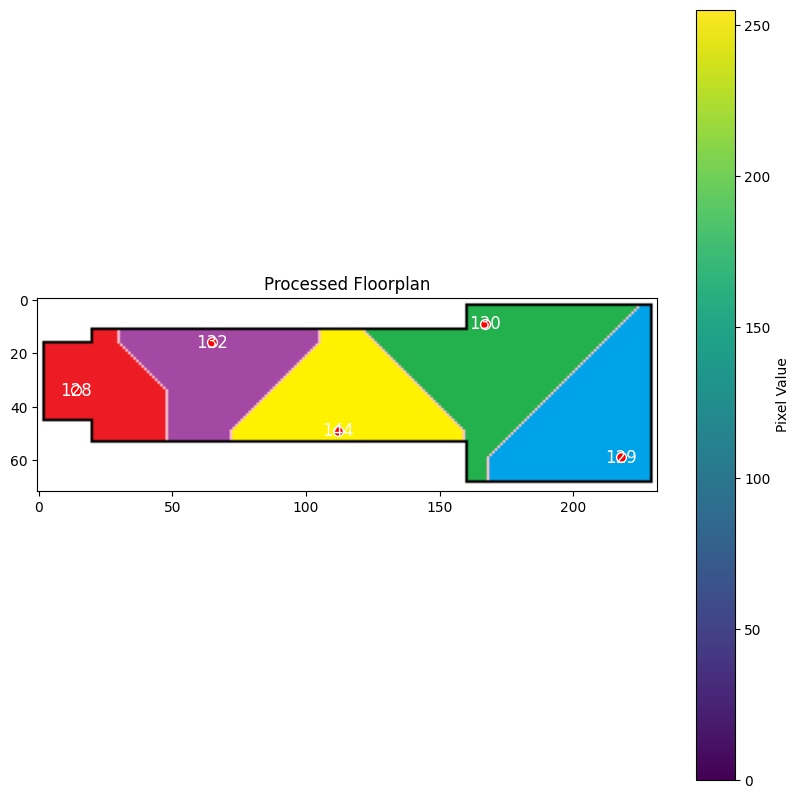

4-Connected Result:
(93, 21, 128)
(21, 51, 132)
(94, 122, 144)
(13, 165, 130)
(232, 190, 129)
(85, 211, 136)


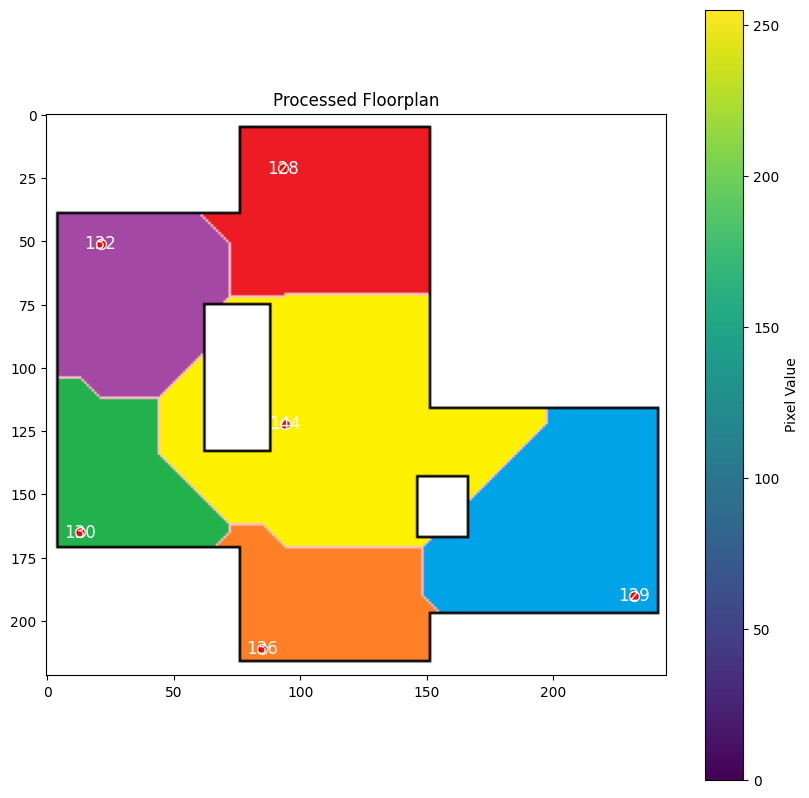

4-Connected Result:
(155, 10, 130)
(14, 55, 128)
(122, 72, 132)
(70, 129, 144)
(148, 139, 129)


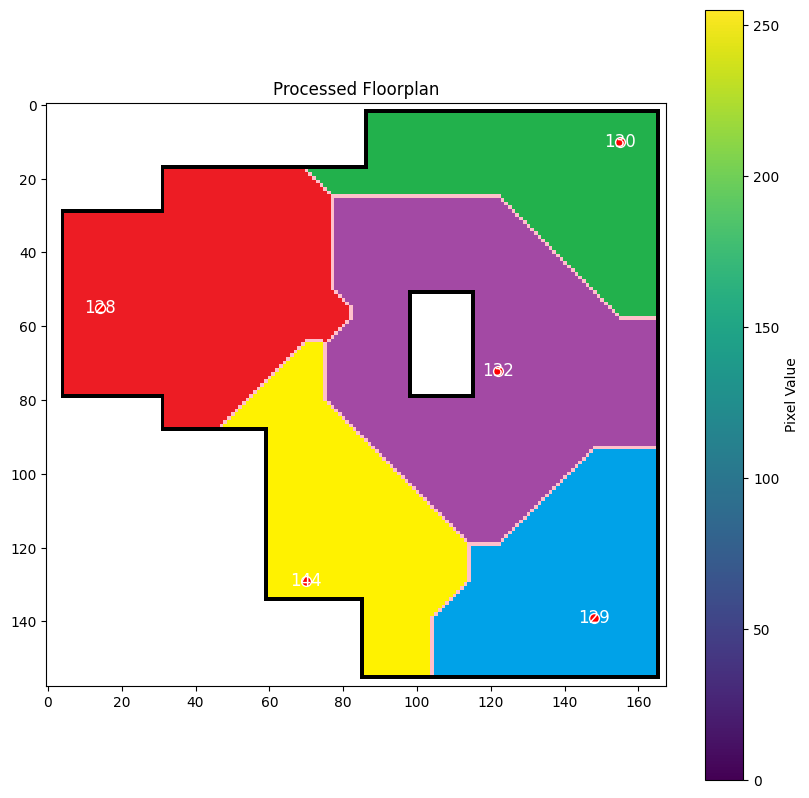

4-Connected Result:
(39, 16, 128)
(108, 40, 129)
(73, 98, 132)
(20, 185, 130)
(133, 188, 144)


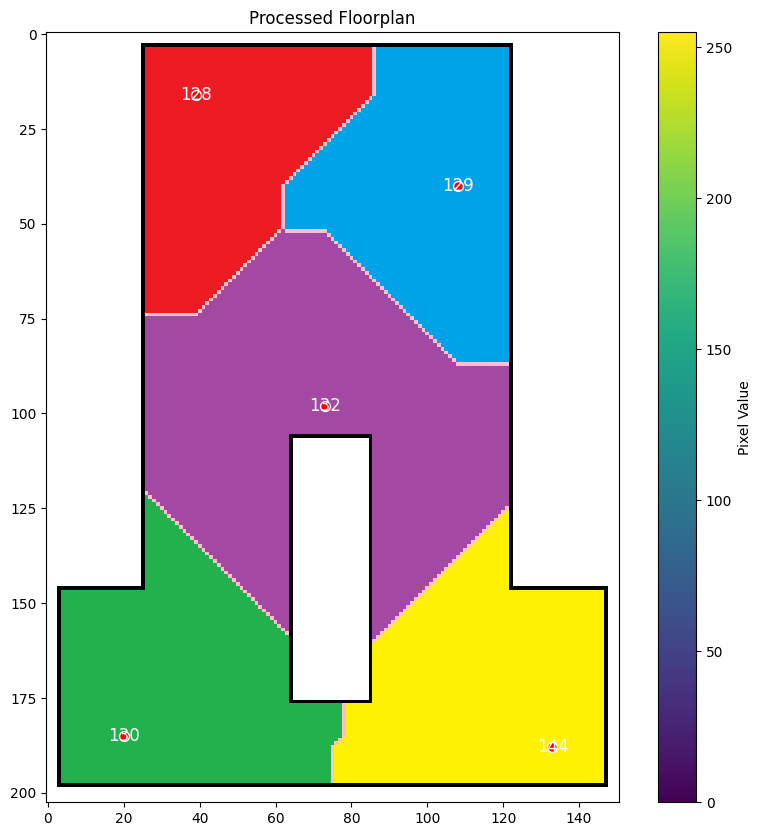

In [218]:
seeded_floorplans = []
for floorplan, seed in zip(floorplans_int[1:], seeds[1:]):
    result_4 = region_growing_simultaneous(floorplan, seed, connectivity=4)
    seeded_floorplans.append(result_4)
    print("4-Connected Result:")
    plot_floorplan(result_4, seed)

    # Perform simultaneous region growing (8-connected)
    #result_8 = region_growing_simultaneous(floorplan, seed, connectivity=8)
    #print("8-Connected Result:")
    #plot_floorplan(result_8, seed)

In [219]:
np.set_printoptions(linewidth=np.inf, threshold=np.inf)
#print(seeded_floorplans[0])